# Scaling the ML Prototype

### Contents:
1. Data
    - Show dataset
    - Show custom dataset
        - Model Training on custom dataset
2. Problem Description
    - Discuss use cases
    - Potential Data Types
        - Live Streaming
            - Wifi Cameras, RTSP, Home Security
        - Batch
            - Parking Lot surveillance
            - Detections DB, Search function, Analytics metrics
3. Scaling
    - Model Performance
        - CPU vs GPU
    - Model Deployment
        - Network Traffic
            - nginx
            - gunicorn
            - AWS: ECR, ECS, and EC2
        - Data Storage
            - Database Solution for Detections
            - Input video handling
            - Detections images handling

## 1. Data

Dataset
- https://viratdata.org/ 
    - hosted locally at /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original

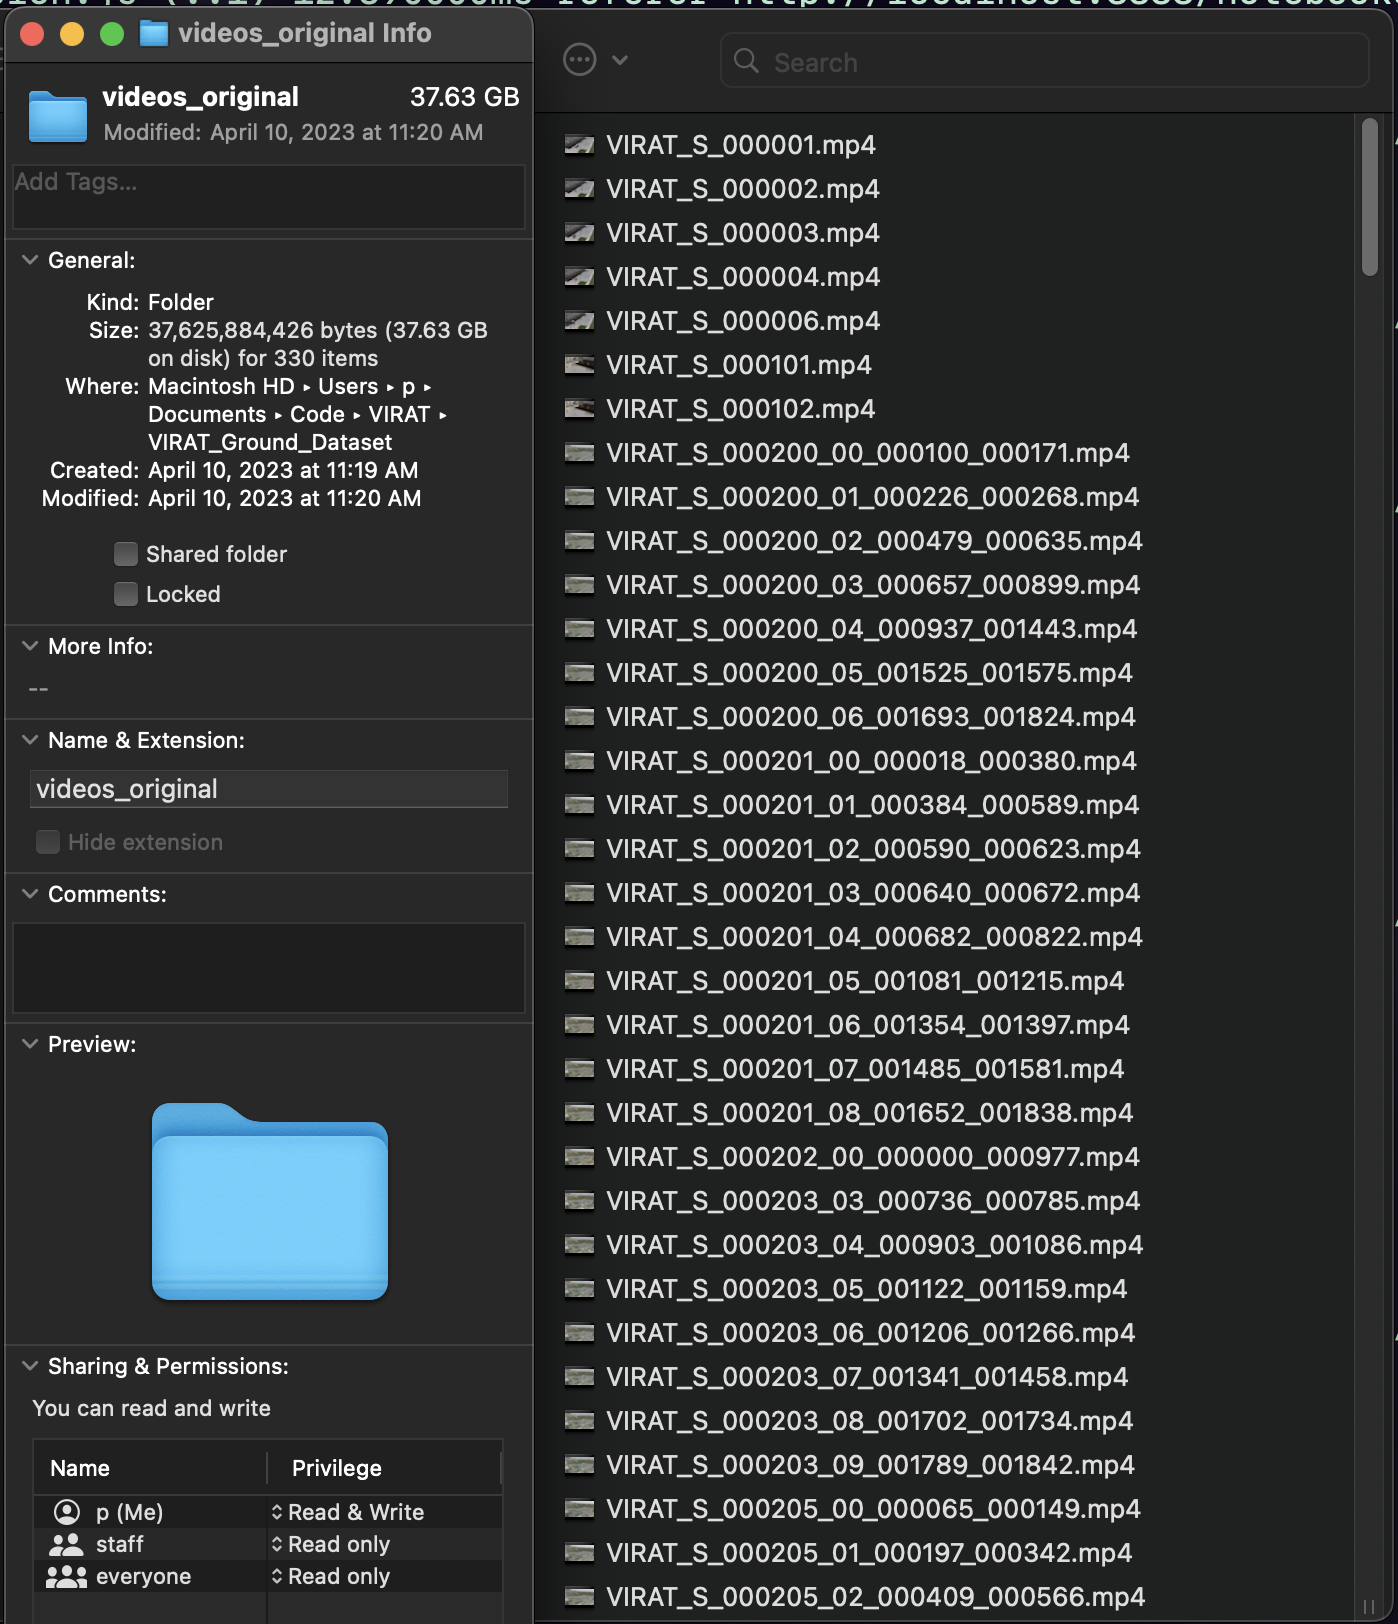

In [1]:
# show raw dataset .mp4 data as its locally hosted
from IPython.display import Image, display
image_path = "/Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/images/VIRAT_Data.png"
display(Image(filename=image_path))

Custom Dataset
- For training
- Sample of images from each video

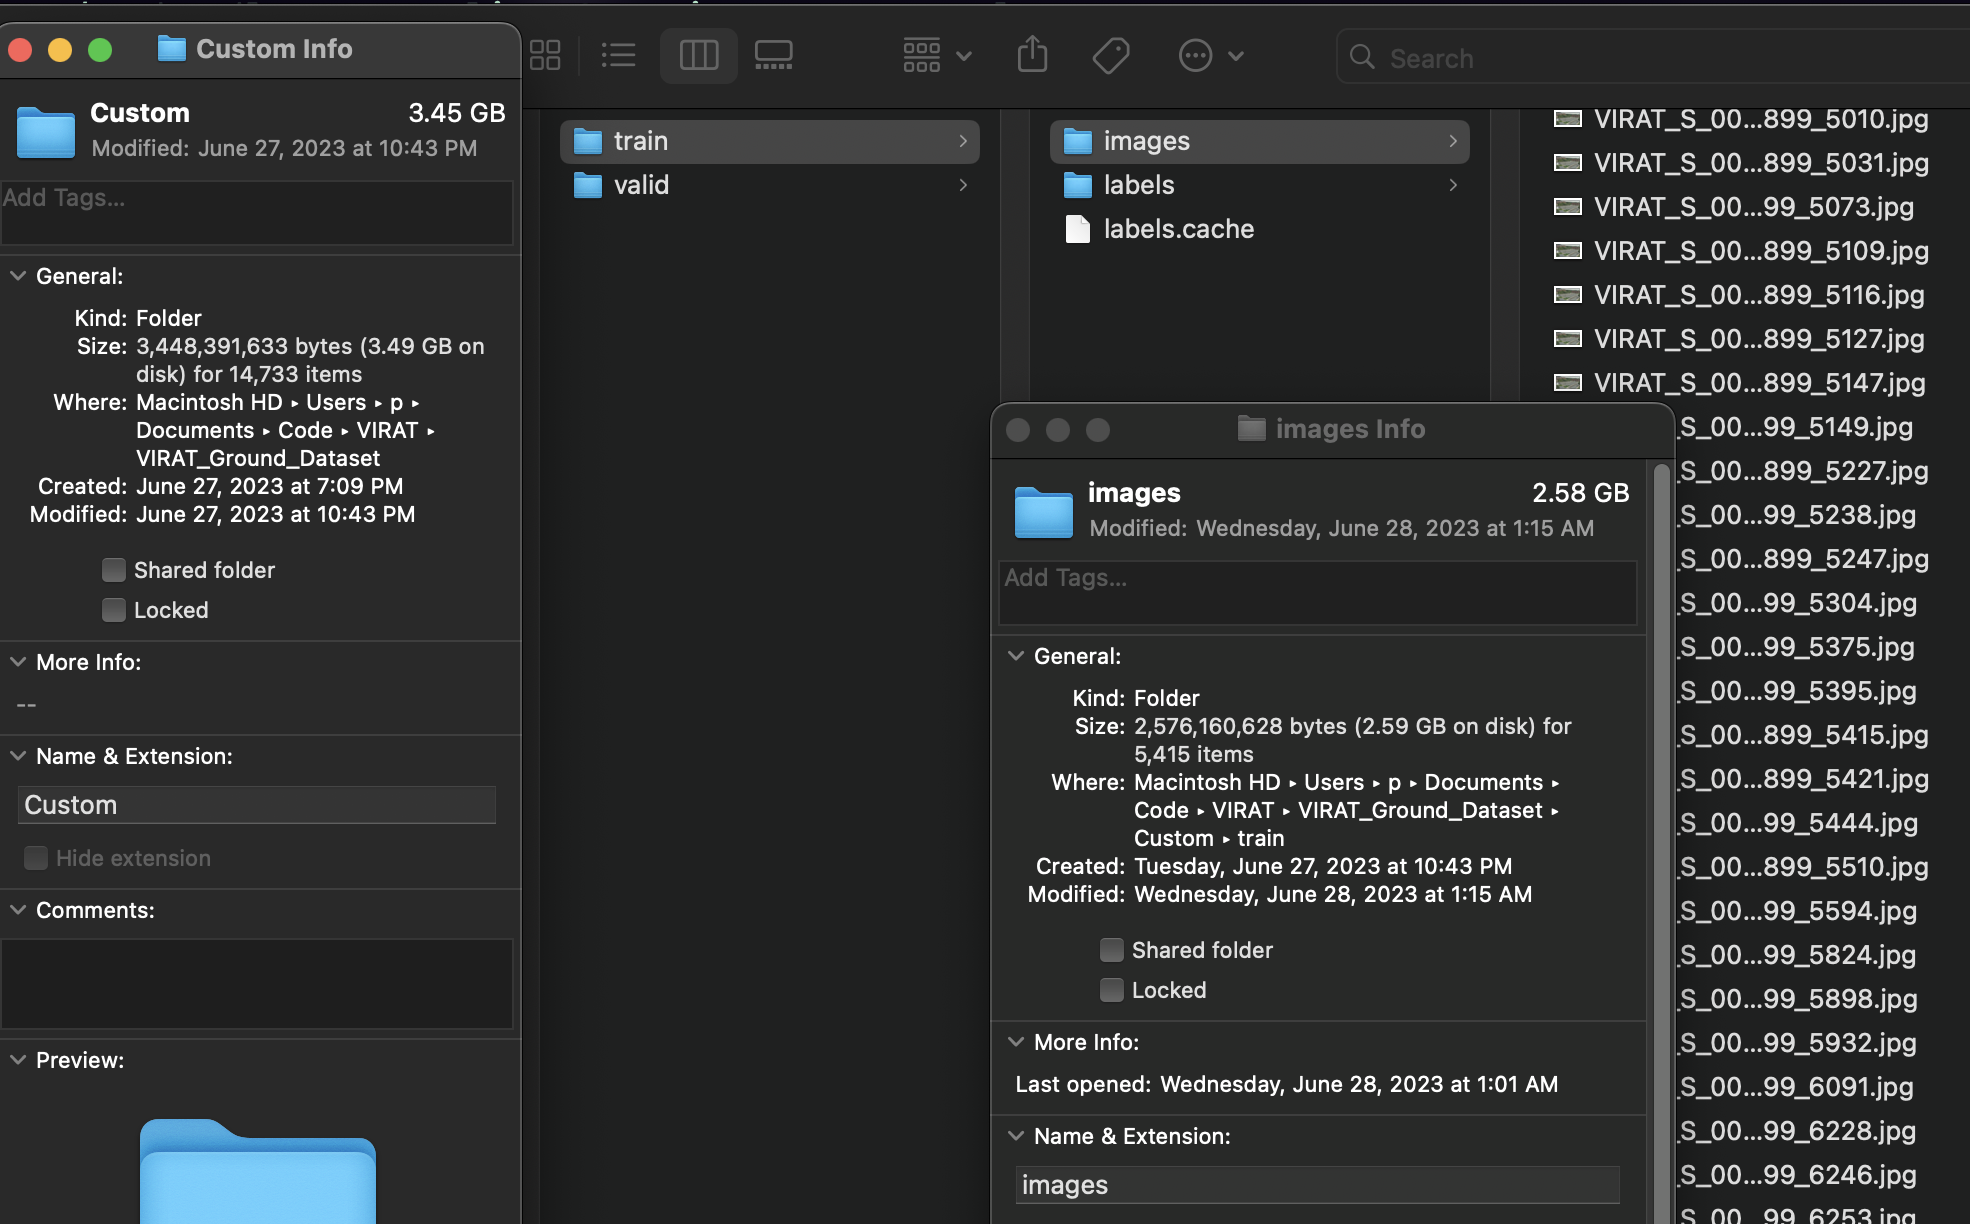

In [2]:
# show custom dataset
image_path = "/Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/images/VIRAT_Custom_Data.png"
display(Image(filename=image_path))

##### Model Training on Custom Dataset
- Original Notebook: https://github.com/DawdlingDaedalus/VIRAT/blob/main/analysis/7.4-Training_on_Custom_Dataset.ipynb
- Results saved to: '/Users/p/Documents/GitHub/VIRAT/analysis/runs/detect/train3/weights/best.pt'

In [6]:
# show .yaml file passed to YOLOv8 model for training
!cat /Users/p/Documents/GitHub/VIRAT/analysis/custom.yaml

path: '/Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/Custom/'
train: 'train/images'
val: 'valid/images'
    
# class names
names:
    0: 'Person'
    1: 'Vehicle'


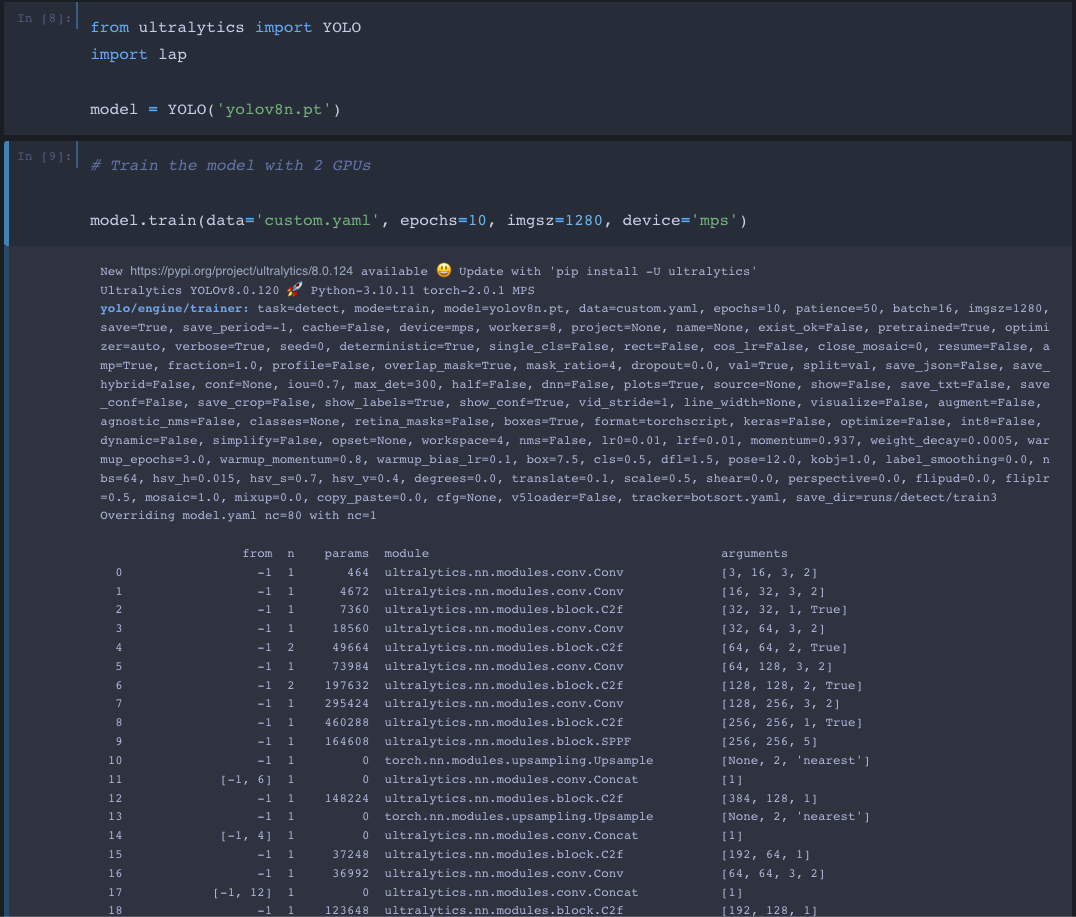

In [7]:
# From Original Notebook, show model instantiation and training

image_path = '/Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/images/Model_Training_01.png'
display(Image(filename=image_path))

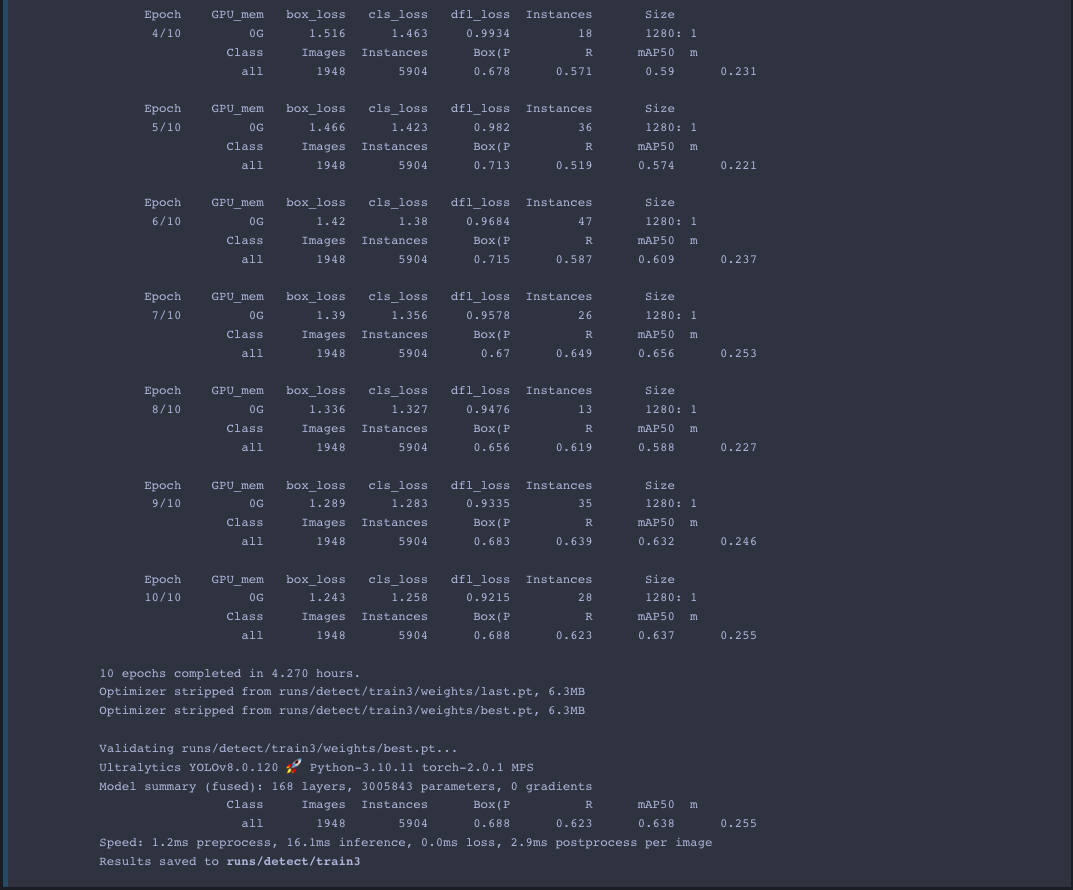

In [8]:
# show training, cont.

image_path = '/Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/images/Model_Training_02.png'
display(Image(filename=image_path))

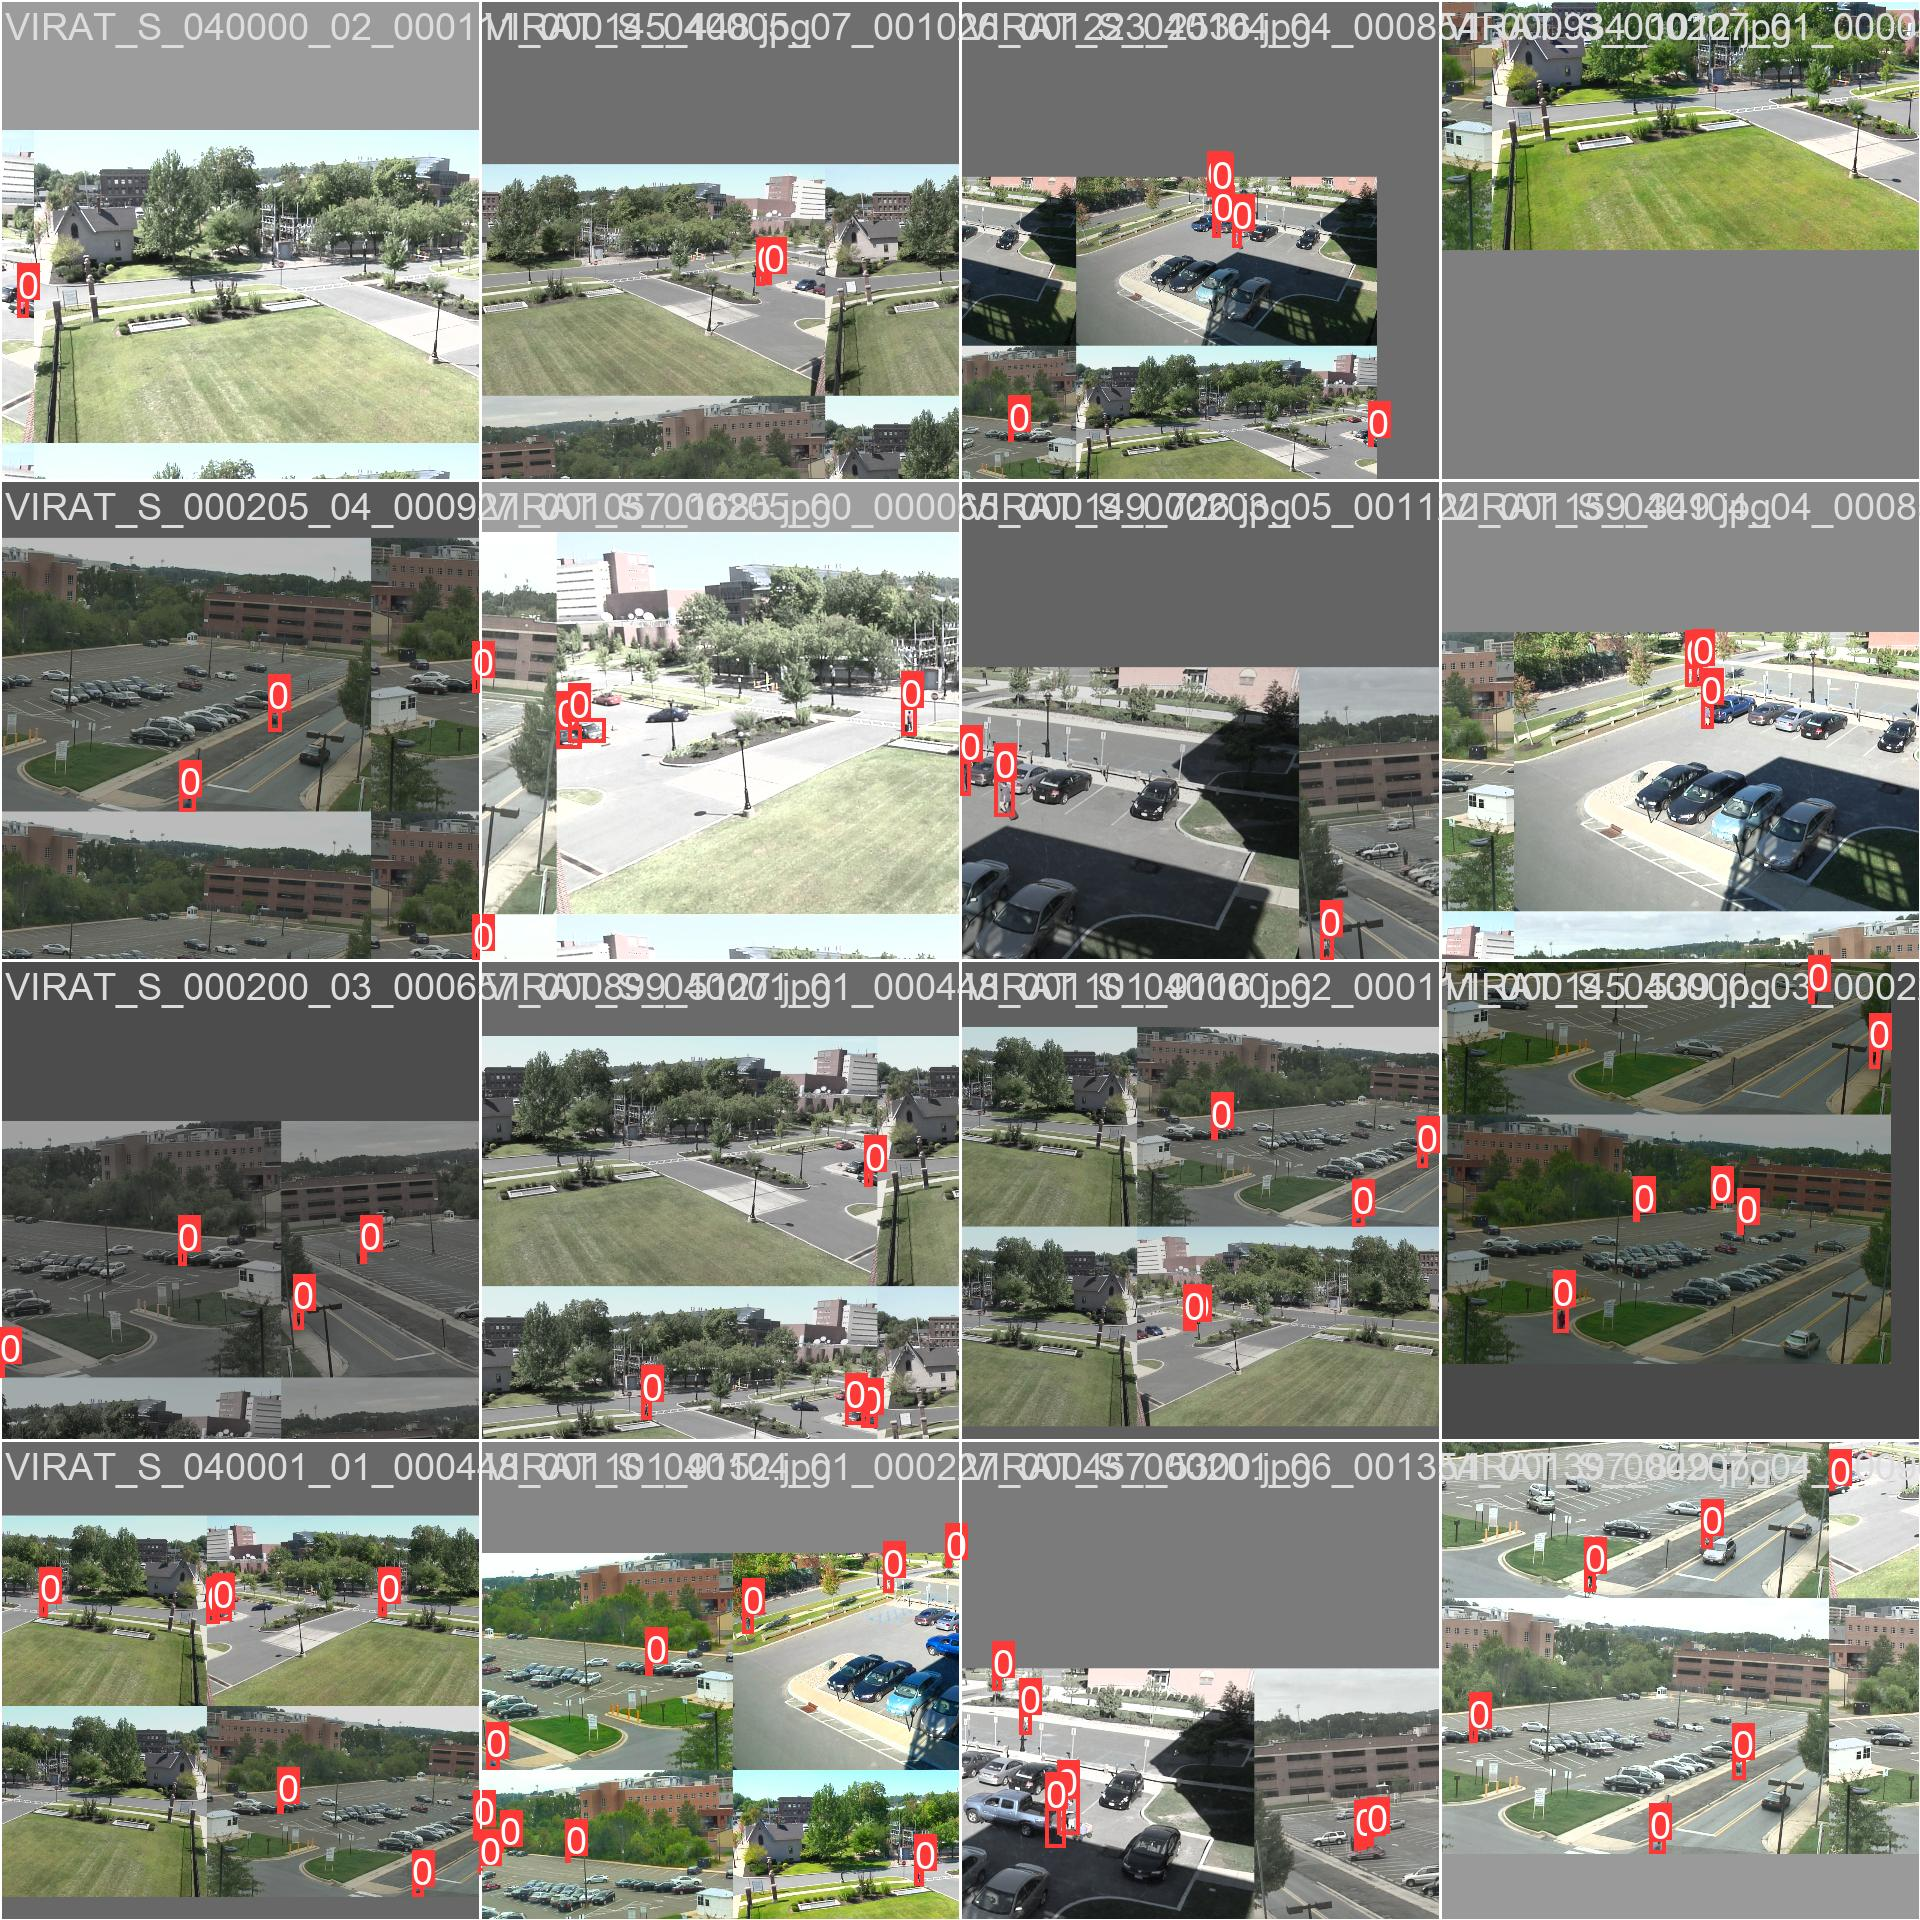

In [9]:
image_path = "/Users/p/Documents/GitHub/VIRAT/analysis/runs/detect/train3/train_batch2.jpg"
display(Image(image_path))

### 2. Problem Description

Video Surveillance is costly. Leveraging AI, we can automate detections. Storing this detections data, we can quickly search through a long period of video capture for people, cars, pets, and other detections we may want to have eyes on.

Use Cases:
1. Personal use as a home surveillance solution
    - Real-time inference from video stream
        - YOLOv8 has a `stream=True/False` parameter which allows for real-time video stream predictions
        - Need a wifi-compatible camera which can stream to a server (Local NAS System, or Cloud Server) via Real-Time Streaming Protocol (RTSP)
        - Options:
            - Wyze Cam v3 with hacked solution 
                - https://github.com/gtxaspec/wz_mini_hacks/tree/master
                - https://forums.wyze.com/t/recording-to-a-personal-cloud/219468
            - Other Wifi-capable cameras with RTSP Stream capabilities
                - https://www.epiphan.com/userguides/pearl-2/Content/capture/sourceIPCameras.htm
                </br>
                </br>
2. Business Solution for detection search and analytics
    - Batch inference at end-of-day to reduce data storage costs
        - Large video files replaced with a Relational Database and .jpgs of detections
        - Analytics can be performed on this data
        - Bad Actors can quickly be discovered based on timestamp

1. Personal use as a home surveillance solution
    - Not implemented (yet)

##### 2. Business Solution for detection search and analytics
- Handle Detections
    - Class to store detections in Pandas Dataframe
        - Detections Data and Images are then stored in AWS S3 bucket

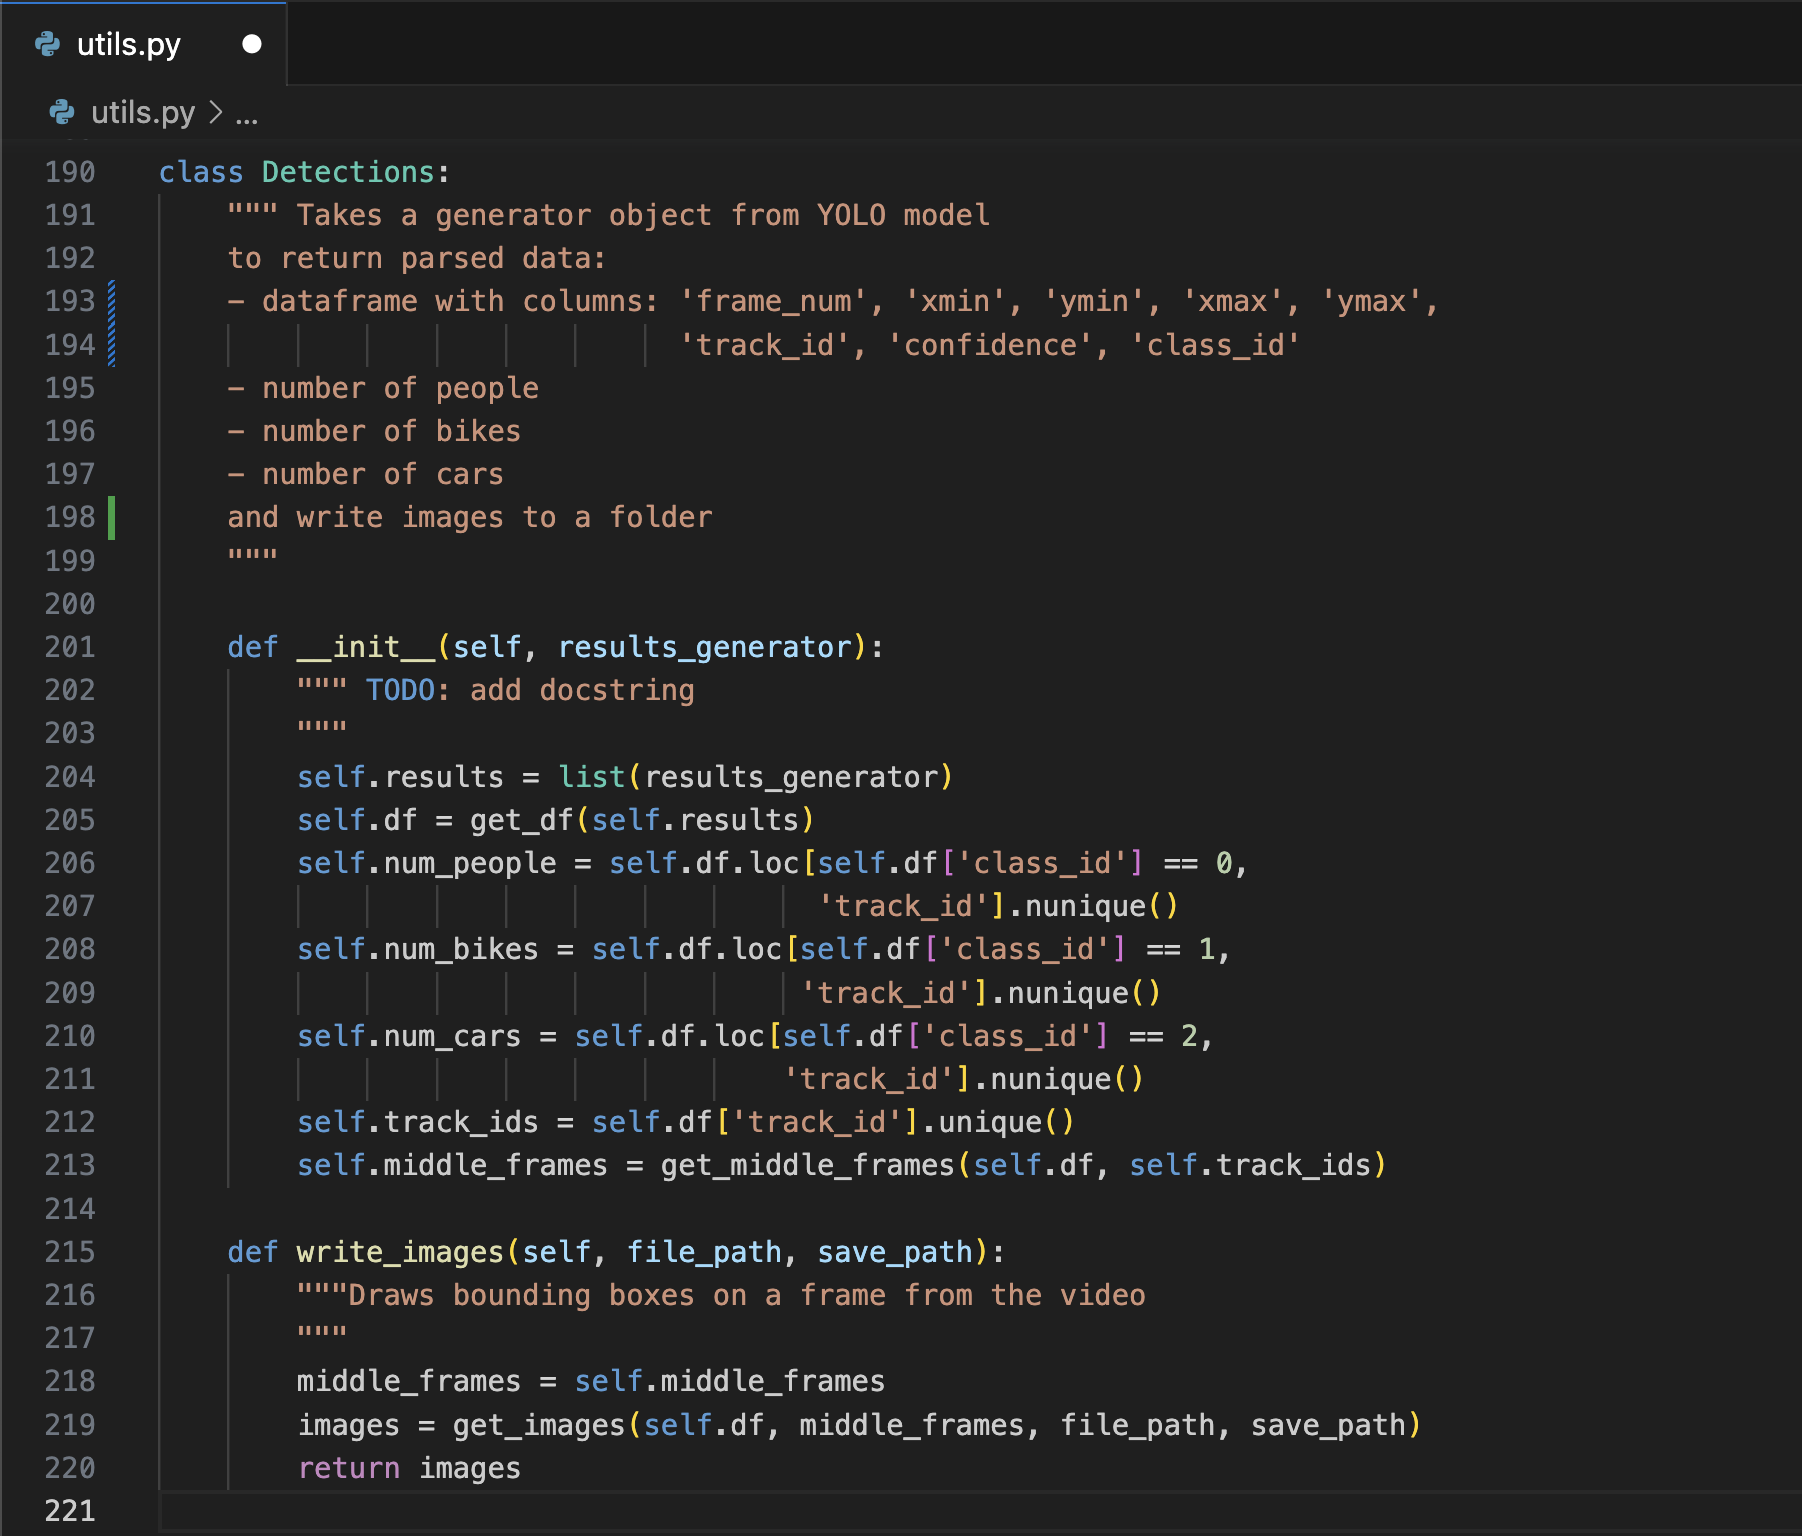

In [10]:
# Detections Class to handle data
image_path = '/Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/images/Detections_Class.png'
display(Image(image_path))

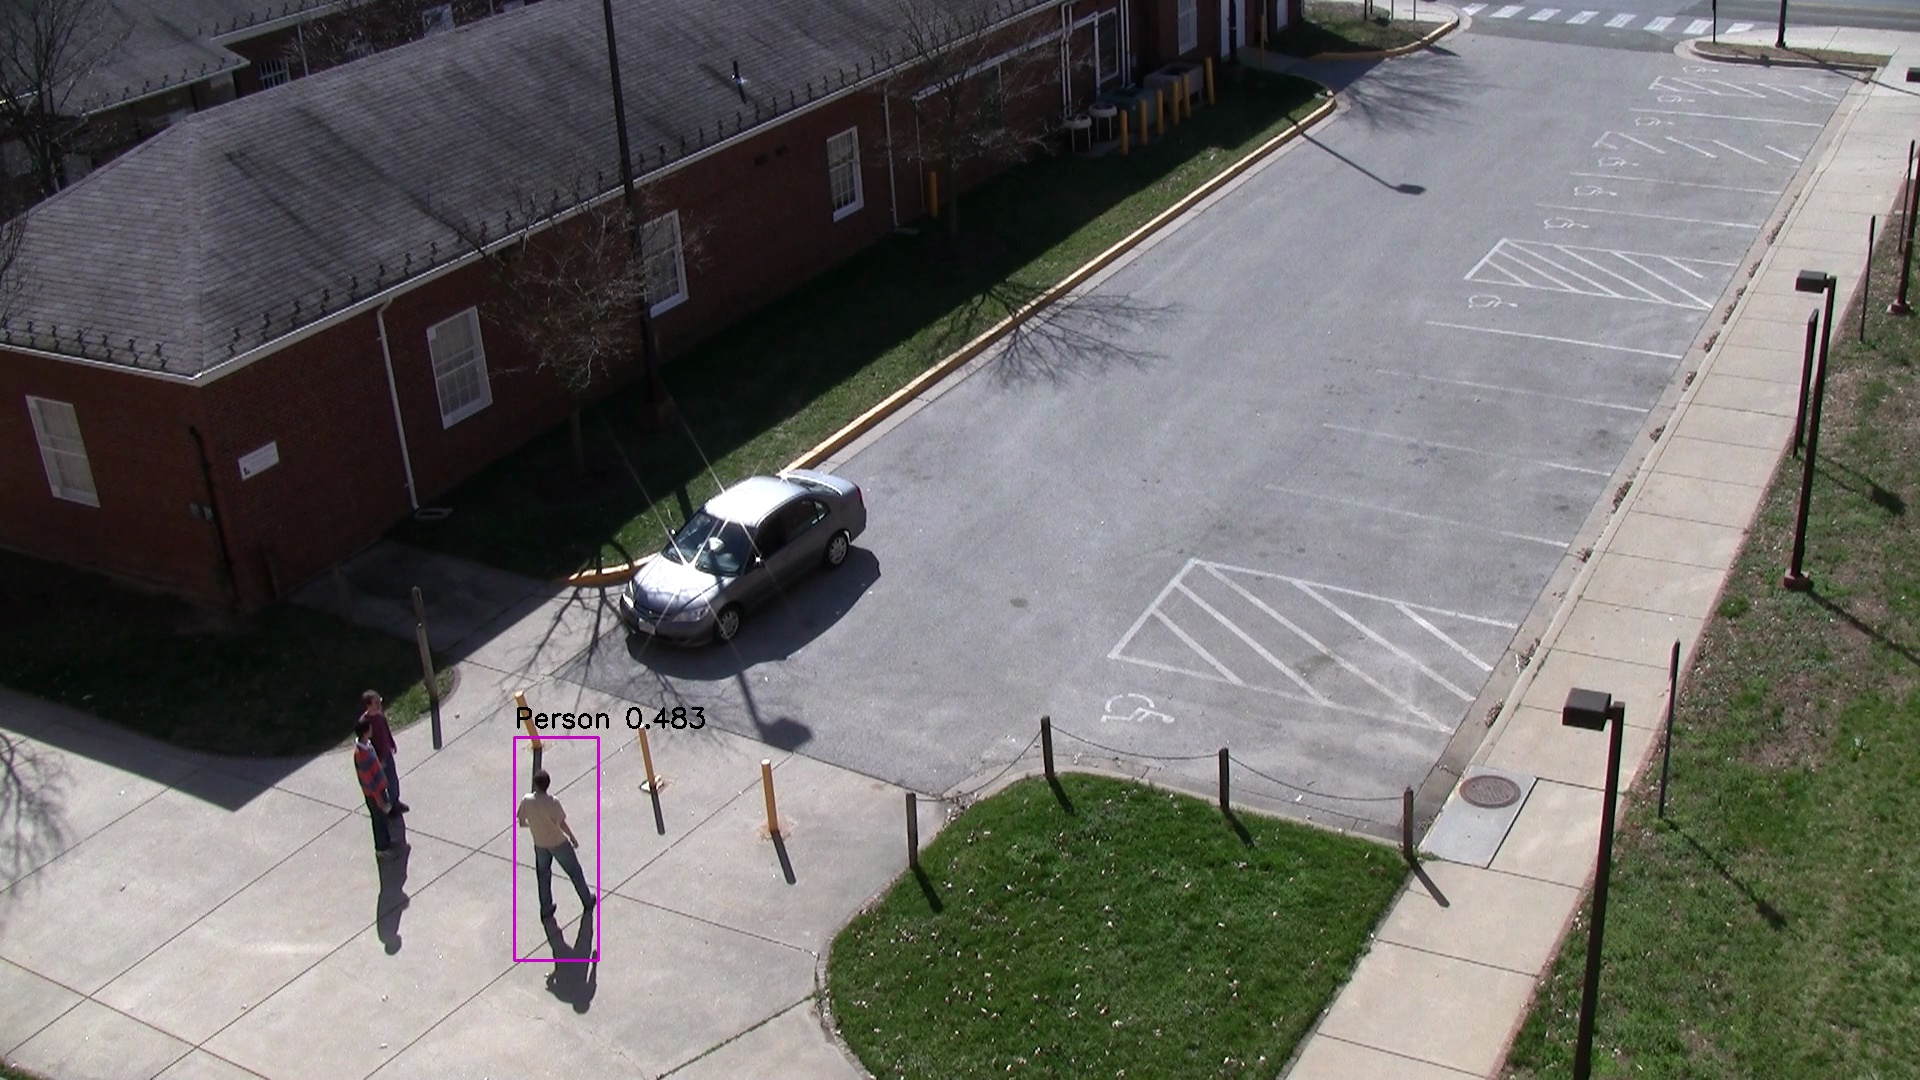

In [13]:
# Images are written with bounding boxes with name "detection[track_ID]_[label].jpg"
image_path = '/Users/p/Documents/GitHub/video-metrics/images/detection1_Person.jpg'
display(Image(image_path))

### 3. Scaling
- Model Performance
    - CPU vs GPU
- Model Deployment
    - Network Traffic
        - nginx
        - gunicorn
        - AWS: ECR, ECS, and EC2
    - Data Storage
        - Database Solution for Detections
        - Input video handling
        - Detections images handling

### Time

Model Performance: Time
- CPU inference is much slower than GPU inference

### CPU Inference

In [16]:
from ultralytics import YOLO
import lap
import os
import contextlib

In [30]:
# run inference using cpu and our trained model
model = YOLO('/Users/p/Documents/GitHub/VIRAT/analysis/runs/detect/train3/weights/best.pt')

In [31]:
# cpu inference, cont.
video = '/Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4'
results = model.track(source=video, conf=0.12, iou=0.5, device='cpu',
                      save_txt=True, imgsz=1920, classes=[0,1,2], tracker="bytetrack.yaml", stream=True)

In [32]:
# CPU inference
%%time

list_results = list(results)

# CPU times: user 12min 21s, sys: 3min 49s, total: 16min 11s
# Wall time: 3min 54s


video 1/1 (1/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 5 Persons, 205.6ms
video 1/1 (2/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 6 Persons, 195.8ms
video 1/1 (3/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 5 Persons, 197.5ms
video 1/1 (4/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 4 Persons, 196.6ms
video 1/1 (5/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 4 Persons, 201.9ms
video 1/1 (6/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 4 Persons, 197.9ms
video 1/1 (7/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/V

video 1/1 (55/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 194.8ms
video 1/1 (56/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 199.5ms
video 1/1 (57/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 200.2ms
video 1/1 (58/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 223.1ms
video 1/1 (59/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 224.4ms
video 1/1 (60/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 192.6ms
video 1/1 (61/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/V

video 1/1 (109/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 195.5ms
video 1/1 (110/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 191.8ms
video 1/1 (111/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 188.0ms
video 1/1 (112/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 185.9ms
video 1/1 (113/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 187.2ms
video 1/1 (114/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 192.8ms
video 1/1 (115/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_ori

video 1/1 (163/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 195.8ms
video 1/1 (164/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 200.5ms
video 1/1 (165/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 193.3ms
video 1/1 (166/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 194.1ms
video 1/1 (167/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 195.8ms
video 1/1 (168/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 198.1ms
video 1/1 (169/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_ori

video 1/1 (217/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 193.8ms
video 1/1 (218/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 194.7ms
video 1/1 (219/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 192.8ms
video 1/1 (220/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 191.9ms
video 1/1 (221/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 195.3ms
video 1/1 (222/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 193.9ms
video 1/1 (223/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_ori

video 1/1 (271/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 188.5ms
video 1/1 (272/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 192.2ms
video 1/1 (273/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 189.3ms
video 1/1 (274/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 3 Persons, 189.0ms
video 1/1 (275/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 189.3ms
video 1/1 (276/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 187.8ms
video 1/1 (277/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/video

video 1/1 (325/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 5 Persons, 188.0ms
video 1/1 (326/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 5 Persons, 185.9ms
video 1/1 (327/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 5 Persons, 194.9ms
video 1/1 (328/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 5 Persons, 188.8ms
video 1/1 (329/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 4 Persons, 183.7ms
video 1/1 (330/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 5 Persons, 190.6ms
video 1/1 (331/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/vide

video 1/1 (379/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 189.6ms
video 1/1 (380/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 193.5ms
video 1/1 (381/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 195.5ms
video 1/1 (382/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 191.5ms
video 1/1 (383/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 199.3ms
video 1/1 (384/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 201.1ms
video 1/1 (385/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_ori

video 1/1 (433/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 195.2ms
video 1/1 (434/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 188.7ms
video 1/1 (435/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 185.8ms
video 1/1 (436/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 189.3ms
video 1/1 (437/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 189.9ms
video 1/1 (438/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 187.3ms
video 1/1 (439/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_or

video 1/1 (487/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 190.5ms
video 1/1 (488/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 188.9ms
video 1/1 (489/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 194.4ms
video 1/1 (490/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 186.2ms
video 1/1 (491/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 192.5ms
video 1/1 (492/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 186.8ms
video 1/1 (493/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/vide

video 1/1 (541/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 190.2ms
video 1/1 (542/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 192.5ms
video 1/1 (543/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 185.4ms
video 1/1 (544/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 192.1ms
video 1/1 (545/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 213.8ms
video 1/1 (546/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 203.3ms
video 1/1 (547/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/vide

video 1/1 (595/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 185.3ms
video 1/1 (596/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 184.1ms
video 1/1 (597/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 190.0ms
video 1/1 (598/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 188.7ms
video 1/1 (599/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 192.5ms
video 1/1 (600/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 2 Persons, 196.0ms
video 1/1 (601/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/vide

video 1/1 (649/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 194.9ms
video 1/1 (650/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 192.2ms
video 1/1 (651/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 198.8ms
video 1/1 (652/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 193.3ms
video 1/1 (653/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 192.3ms
video 1/1 (654/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 200.2ms
video 1/1 (655/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_ori

video 1/1 (703/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 193.8ms
video 1/1 (704/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 189.6ms
video 1/1 (705/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 193.5ms
video 1/1 (706/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 191.4ms
video 1/1 (707/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 192.3ms
video 1/1 (708/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 196.9ms
video 1/1 (709/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_ori

video 1/1 (757/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 190.5ms
video 1/1 (758/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 195.1ms
video 1/1 (759/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 193.5ms
video 1/1 (760/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 193.0ms
video 1/1 (761/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 198.4ms
video 1/1 (762/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 188.4ms
video 1/1 (763/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_ori

video 1/1 (811/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 195.9ms
video 1/1 (812/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 197.9ms
video 1/1 (813/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 191.3ms
video 1/1 (814/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 183.8ms
video 1/1 (815/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 187.6ms
video 1/1 (816/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 189.2ms
video 1/1 (817/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_ori

video 1/1 (865/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 186.5ms
video 1/1 (866/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 187.9ms
video 1/1 (867/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 186.9ms
video 1/1 (868/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 190.5ms
video 1/1 (869/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 189.5ms
video 1/1 (870/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 189.1ms
video 1/1 (871/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_ori

video 1/1 (919/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 202.3ms
video 1/1 (920/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 192.6ms
video 1/1 (921/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 189.5ms
video 1/1 (922/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 190.9ms
video 1/1 (923/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 187.3ms
video 1/1 (924/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 197.9ms
video 1/1 (925/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_ori

video 1/1 (973/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 192.3ms
video 1/1 (974/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 205.6ms
video 1/1 (975/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 207.8ms
video 1/1 (976/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 196.2ms
video 1/1 (977/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 198.8ms
video 1/1 (978/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 196.2ms
video 1/1 (979/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_ori

video 1/1 (1027/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 185.4ms
video 1/1 (1028/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 189.1ms
video 1/1 (1029/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 187.5ms
video 1/1 (1030/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 192.7ms
video 1/1 (1031/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 192.1ms
video 1/1 (1032/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 191.8ms
video 1/1 (1033/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/vid

video 1/1 (1081/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 192.0ms
video 1/1 (1082/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 196.4ms
video 1/1 (1083/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 189.4ms
video 1/1 (1084/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 193.4ms
video 1/1 (1085/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 189.4ms
video 1/1 (1086/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 183.7ms
video 1/1 (1087/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/vid

video 1/1 (1135/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 192.1ms
video 1/1 (1136/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 198.9ms
video 1/1 (1137/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 232.2ms
video 1/1 (1138/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 199.4ms
video 1/1 (1139/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 192.3ms
video 1/1 (1140/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/videos_original/VIRAT_S_010109_04_000487_000538.mp4: 1088x1920 1 Person, 193.2ms
video 1/1 (1141/1146) /Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/vid

CPU times: user 12min 21s, sys: 3min 49s, total: 16min 11s
Wall time: 3min 54s


### GPU Inference

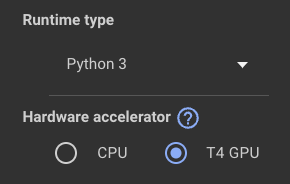

In [34]:
# Show GPU being used. It's a 'T4 GPU' hardware accelerator available from Google Colab Notebooks
image_path = '/Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/images/Runtime_Type.png'
display(Image(image_path))

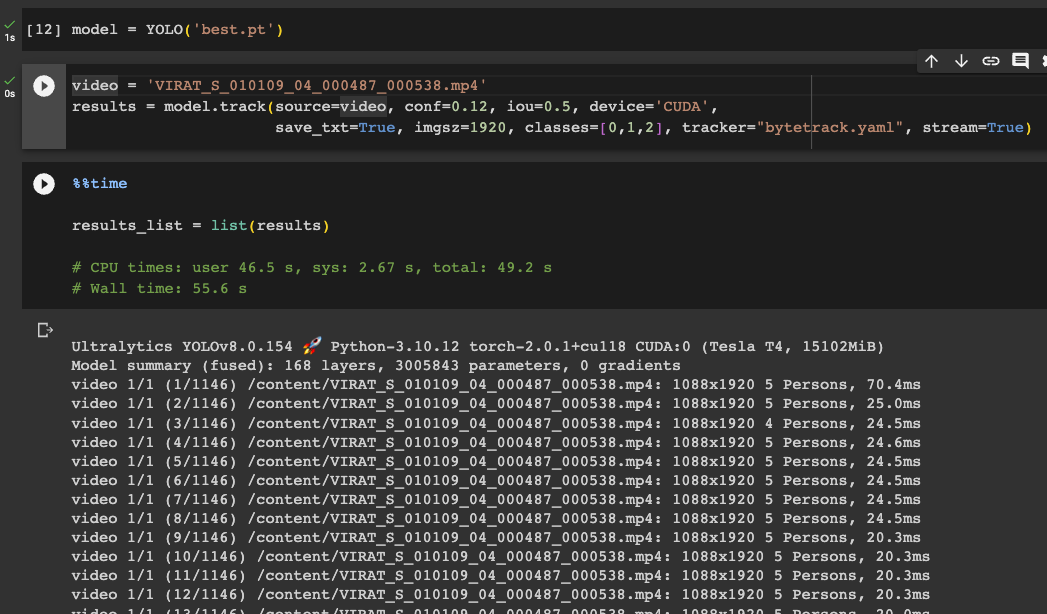

In [35]:
# GPU inference
image_path = '/Users/p/Documents/Code/VIRAT/VIRAT_Ground_Dataset/images/Runtime_GPU_Performance.png'
display(Image(image_path))

# CPU times: user 46.5 s, sys: 2.67 s, total: 49.2 s
# Wall time: 55.6 s

GPU Inference is over 4 times faster than CPU.